# 04. PyTorch Custom Datasets 

We used some datasets with PyTorch before.

How to use own data?

One of the ways to do so is using custom datasets.

**Resources**: 
- Book version on learnpytorch.io
- Notebook on Daniel's Github

## Domain libraries

Depending on what is working on, vision, text, audio, recommendations.... -> PyTorch domain libs


## Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# PyTorch 1.10+ is needed
print(f"Torch version: {torch.__version__}")
print(f"Torch build cuda version: {torch.version.cuda}")

Torch version: 2.5.1
Torch build cuda version: 11.8


In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [4]:
!nvidia-smi

Thu Nov 21 10:08:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8             12W /   40W |     193MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get some data

The dataset is a subset of the food101 dataset, which starts with 101 different classes of food. The following dataset is reduced to three classes and 1000 images.

It's important to try on a small scale and then increase the scale when necessary.

In [5]:
import requests
import zipfile
from pathlib import Path
import os

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download


Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [6]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(data_path)

There are 2 directories and 1 images in 'data'.
There are 1 directories and 0 images in 'data\FashionMNIST'.
There are 0 directories and 8 images in 'data\FashionMNIST\raw'.
There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [8]:
# Setup train and test directories
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

train_dir, test_dir

('data\\pizza_steak_sushi\\train', 'data\\pizza_steak_sushi\\test')

### 2.1 Visualize an image

Let's write some code to:
1. Get all of the image's paths
2. Pick a random image path using Python's `random.choice`
3. Get the imgage class name with `pathlit.Path.parent.stem`
4. Open the image with Pillow
5. Show the image and print metadata

In [9]:
image_path

WindowsPath('data/pizza_steak_sushi')

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height x width: (512, 408)


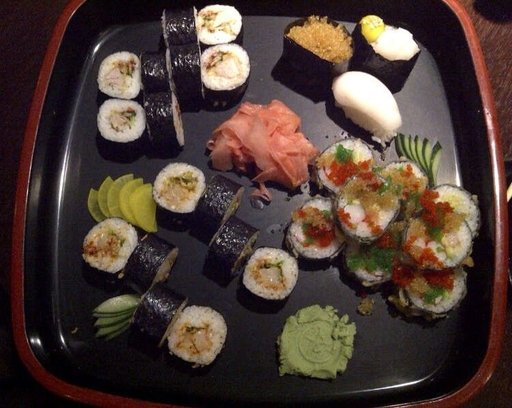

In [10]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get  imga paths list
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the class name
image_class = random_image_path.parent.stem
print(image_class)

# 4. OPen image
img = Image.open(random_image_path)

# 5. Print metadata of image
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height x width: {img.size}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

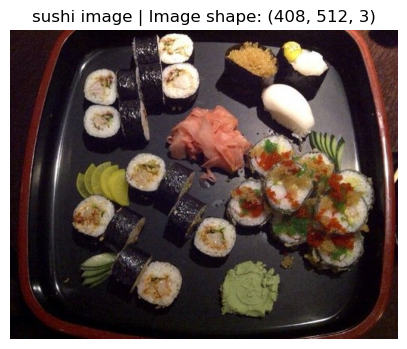

In [11]:
import numpy as np
import random

# Visualize an image with matplotlib
import matplotlib.pyplot as plt

img_as_array = np.array(img)
# Erst als array, bekommt man die Anzahl der Farbkanäle über shape

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"{image_class} image | Image shape: {img_as_array.shape}")
plt.axis(False)


## 3. Transforming data

Before one can use the image data with PyTorch:
1. Turn the target data into tensors (in this case a numerical representation of the images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data` and `Dataloader`

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

Transform help, to get the images ready to be used with a model/perform data augmentation

In [13]:
# Write a transform to turn images into tensors
data_transform = transforms.Compose([ # nn.sezuential würde auch funktionieren
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [14]:
data_transform(img)

tensor([[[0.0824, 0.0824, 0.0863,  ..., 0.1412, 0.1373, 0.1294],
         [0.0902, 0.0902, 0.0902,  ..., 0.1412, 0.1373, 0.1255],
         [0.1137, 0.0980, 0.1059,  ..., 0.1333, 0.1412, 0.1294],
         ...,
         [0.1412, 0.1373, 0.1294,  ..., 0.0157, 0.0196, 0.0157],
         [0.1333, 0.1373, 0.1255,  ..., 0.0275, 0.0275, 0.0275],
         [0.1255, 0.1294, 0.1137,  ..., 0.0275, 0.0314, 0.0314]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0667, 0.0588, 0.0588],
         [0.0353, 0.0431, 0.0392,  ..., 0.0667, 0.0549, 0.0588],
         [0.0392, 0.0471, 0.0471,  ..., 0.0627, 0.0627, 0.0510],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.0078, 0.0078, 0.0039],
         [0.0667, 0.0706, 0.0706,  ..., 0.0118, 0.0118, 0.0118],
         [0.0667, 0.0667, 0.0667,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.0745, 0.0706, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0863, 0.0902, 0.0941,  ..., 0.0863, 0.0784, 0.0784],
         [0.1137, 0.1059, 0.0941,  ..., 0.0941, 0.0863, 0.

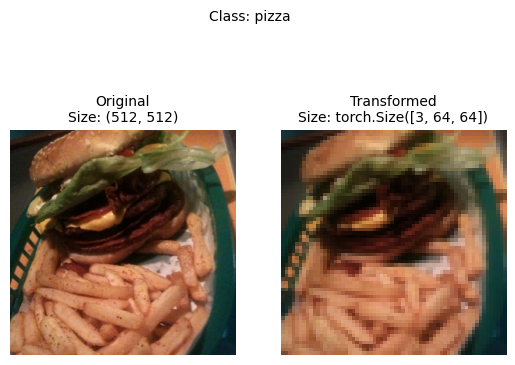

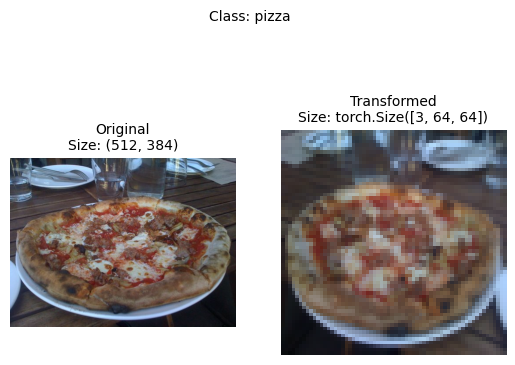

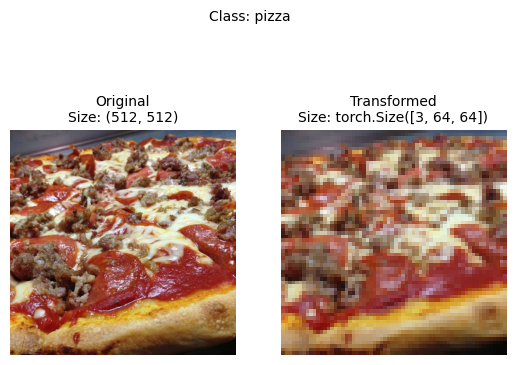

In [15]:
def plot_transformed_images(
    image_paths: list, 
    transform, 
    n=3, 
    seed=None):
    """
    Picks n random images from image_paths and displays them with transform applied.
    """

    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2,)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}", fontsize=10)
            ax[0].axis(False)

            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}", fontsize=10)
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=10)

plot_transformed_images(
    image_paths=image_path_list, 
    transform=data_transform, 
    n=3,
    seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

One can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# Use image folders to create datasets
from torchvision.datasets import ImageFolder

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of the datasets
len(train_data), len(test_data)

(225, 75)

In [20]:
# idx on train_data DAtaset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image type: {type(img)}")
print(f"Image dtype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label type: {type(label)}")

Image tensor: 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [21]:
# Rearrange the image tensor shape
img_permute = img.permute(1, 2, 0)

print(f"Image tensor shape: {img.shape}")
print(f"Image tensor shape rearranged: {img_permute.shape}")

Image tensor shape: torch.Size([3, 64, 64])
Image tensor shape rearranged: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'Class: pizza')

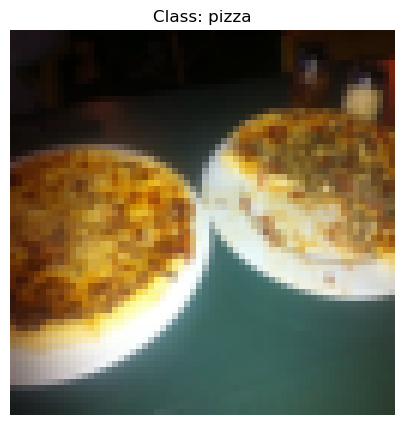

In [22]:
# Plot with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(img_permute)
plt.title(f"Class: {class_names[label]}")
plt.axis(False)
plt.title(f"Class: {class_names[label]}")

## 4.1 Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us, turn our `Dataset`'s into iterables and we can cutsomise the `batch_size` so our model can see `bath_size` images at a time.

In [23]:
print(f"CPU Count: {os.cpu_count()}")

CPU Count: 16


In [24]:
# Turn train and test datasets into data loaders
BATCH_SIZE = 1

train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

In [25]:
test_loader, train_loader, len(train_loader), len(test_loader)

(<torch.utils.data.dataloader.DataLoader at 0x2641646ee10>,
 225,
 75)

In [26]:
img, label = next(iter(train_loader))

# Batch size will now be 1, one can change it if one wants to
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros: 
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

In [27]:
import os
import torch
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1. Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an erron if the classnames aren't found (sth wrong with directory structure).
3. Turn class names into a dict and return them.

In [29]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir()])
class_names_found

Target directory: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Returns the class names and class indices in a target directory.
    """
    classes = sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])

    if not classes:
        raise FileNotFoundError(f"No class directories found in {directory}.")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init the subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
   * paths - paths of our images
   * transform - the transform we'd like to use
   * classes - a list of the target classes
   * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [32]:
# Write a custom dataset
from torch.utils.data import Dataset

# 1. Subclass the Dataset class
class ImageFolderCustom(Dataset):

    # 2. Initialize the custom dataset
    def __init__(
        self, 
        target_directory: 
        str, transform=None
    ):

        # 3. Creat class attributes
        # Get all of image paths
        self.paths = list(pathlib.Path(target_directory).glob("*/*.jpg"))

        # Setup transforms
        self.transform = transform

        # Create classes and class to idx
        self.classes, self.class_to_idx = find_classes(target_directory)

     # 4. Create fct to load images
    def load_image(
        self,
        index: int) -> Image.Image:
        """
        Loads an image from a file path.
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Override the __len__ method
    def __len__(self) -> int:
        return len(self.paths)

    # 6. Override the __getitem__ method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Load and return a sample from the dataset at the given index.
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [33]:
# Create a transform
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [34]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir, transform=train_transform)
test_data_custom = ImageFolderCustom(target_directory=test_dir, transform=test_transforms)

In [35]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2641685fb30>,
 <__main__.ImageFolderCustom at 0x2641690a360>)

In [36]:
len(train_data), len(train_data_custom)

(225, 225)

In [37]:
len(test_data), len(test_data_custom)

(75, 75)

In [38]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [39]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [40]:
# check for equality between original and custom datasets
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.classes == train_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample imgaes and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).

In [41]:
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None):
    
    if n > 10: 
        n = 10
        display_shape = False
        print(f"n should be less than 10, setting n=10 and display_shape=False.")

    if seed:
        random.seed(seed)

    targ_samples_idx = random.sample(range(len(dataset)), n)

    plt.subplots(nrows=1, ncols=n, figsize=(10, 7))
    for i, targ_sample in enumerate(targ_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_permute = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_permute)
        plt.axis(False)

        if classes:
            title = f"{classes[targ_label]}"
            if display_shape:
                title += f"\n{targ_image_permute.shape}"
        plt.title(title, fontsize=8)
        


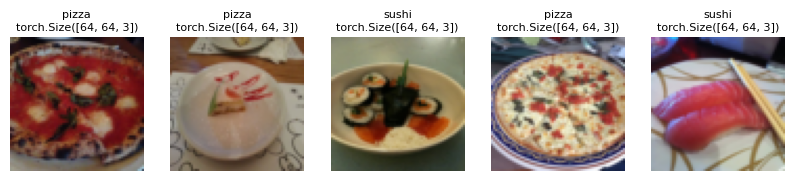

In [42]:
# Display random images from the ImageFolder dataset
display_random_images(
    dataset=train_data,
    classes=class_names,
    n=5,
    display_shape=True,
    seed=None)

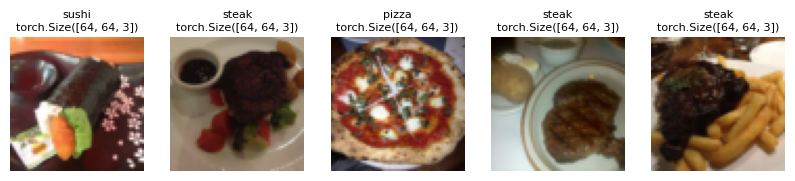

In [43]:
# Display random images from the ImageFolderCustom dataset
display_random_images(
    dataset=train_data_custom,
    classes=class_names,
    n=5,
    display_shape=True,
    seed=None)

### 5.4 Turn custom loaded images to `DataLoader`'s

In [44]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [45]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


## 6. Other forms of transforms

- Data Augmentation is the process of artificially adding diversity to your training data.
- In the case of img data, this may mean applying various img transformations to the training data.#
- This practice hopefully results in a model that's more generalizable to unseen data.
- Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...
- [How to Train State-Of-The-Art Models Using TorchVision’s Latest Primitives](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [46]:
# Trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [47]:
# Get all the image paths
image_paths_list = list(image_path.glob("*/*/*.jpg"))
image_paths_list[:5]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

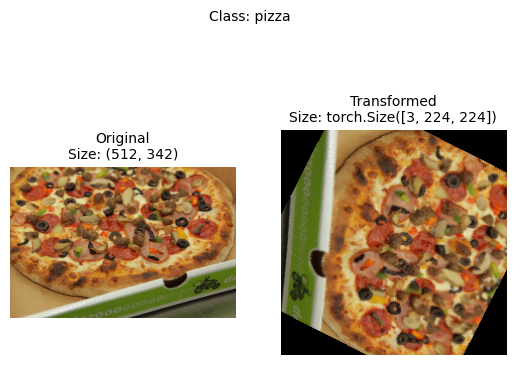

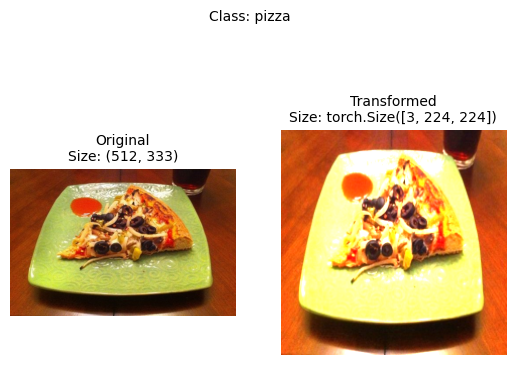

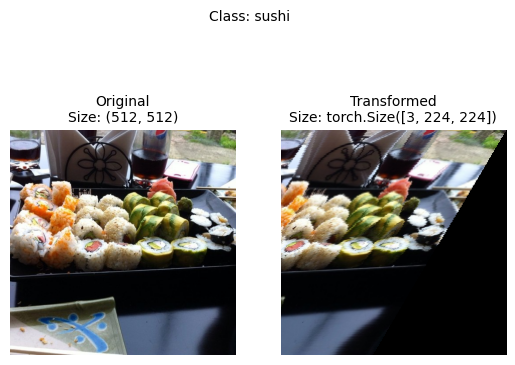

In [48]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_paths_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Replicate TinyVGG from CNN Explainer

### 7.1 Create some transforms and loading data for model_0

In [49]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [50]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform,
)

In [51]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

### 7.2 Creat TinyVGG model class

In [52]:
class TinyVGG(nn.Module):
    """
    Model arch for TinyVGG from CNN Explainer.
    """

    def __init__(
        self,
        input_shape: int,
        hidden_units: int,
        output_shape: int
        ) -> None:

        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, 
                out_channels=hidden_units, 
                kernel_size=3, 
                stride=1, 
                padding=0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units, 
                out_channels=hidden_units, 
                kernel_size=3, 
                stride=1, 
                padding=0),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, 
                stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units, 
                out_channels=hidden_units, 
                kernel_size=3, 
                stride=1, 
                padding=0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units, 
                out_channels=hidden_units, 
                kernel_size=3, 
                stride=1, 
                padding=0),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, 
                stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*13*13,
                out_features=output_shape),
        )

    def forward(
        self, 
        x: torch.Tensor) -> torch.Tensor:
        """
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)

        return x
        """
        
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion
    

In [53]:
torch.manual_seed(42)

model_0 = TinyVGG(
    input_shape=3, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)

In [54]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try forward path on a single image

In [56]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [57]:
model_0(image_batch.to(device))

tensor([[ 0.0196, -0.0014,  0.0108],
        [ 0.0209,  0.0001,  0.0089],
        [ 0.0198, -0.0038,  0.0090],
        [ 0.0191, -0.0013,  0.0104],
        [ 0.0228, -0.0037,  0.0093],
        [ 0.0245, -0.0048,  0.0085],
        [ 0.0209,  0.0001,  0.0084],
        [ 0.0224, -0.0014,  0.0080],
        [ 0.0179,  0.0004,  0.0087],
        [ 0.0186, -0.0042,  0.0095],
        [ 0.0182, -0.0003,  0.0076],
        [ 0.0183, -0.0008,  0.0152],
        [ 0.0183,  0.0002,  0.0060],
        [ 0.0213, -0.0039,  0.0110],
        [ 0.0232, -0.0035,  0.0095],
        [ 0.0198, -0.0023,  0.0090],
        [ 0.0202, -0.0023,  0.0073],
        [ 0.0211, -0.0018,  0.0083],
        [ 0.0203,  0.0033,  0.0065],
        [ 0.0219, -0.0002,  0.0091],
        [ 0.0186, -0.0020,  0.0091],
        [ 0.0205, -0.0025,  0.0085],
        [ 0.0208,  0.0018,  0.0080],
        [ 0.0194,  0.0016,  0.0103],
        [ 0.0216, -0.0044,  0.0095],
        [ 0.0195, -0.0022,  0.0100],
        [ 0.0197, -0.0009,  0.0093],
 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [58]:
from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loops fcts

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [59]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device=device,
    ) -> Tuple[float, float]:

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for (X, y) in dataloader:
        
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc = (y == y_pred_class).sum().item()/len(y_pred)

    return train_loss/len(dataloader), train_acc/len(dataloader)

In [60]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device,
    ) -> Tuple[float, float]:

    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.inference_mode():

        for (X, y) in dataloader:
            
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(test_pred_logits, dim=1)
            test_acc = (y == y_pred_class).sum().item()/len(test_pred_logits)

    return test_loss/len(dataloader), test_acc/len(dataloader)


### 7.6 Creating a `train()` fct to combine `train_step()` and `test_step()`

In [61]:
from tqdm.notebook import tqdm

def train_model(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
    num_epochs: int=5,
    device=device,
    ) -> Tuple[list, list]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(num_epochs)):
            
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
    
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
    
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} | Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}")
    
    return results

### 7.7 Train and evaluate `model_0` 

In [63]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

model_0 = TinyVGG(
    input_shape=3, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)

from timeit import default_timer as timer
start_time=timer()

train_model_results = train_model(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=torch.optim.Adam(model_0.parameters(), lr=0.001),
    loss_fn=nn.CrossEntropyLoss(),
    num_epochs=NUM_EPOCHS,
    device=device
)

print(f"Elapsed time: {timer()-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50 | Train loss: 1.11 | Train acc: 0.00 | Test loss: 1.10 | Test acc: 0.03
Epoch: 2/50 | Train loss: 1.10 | Train acc: 0.00 | Test loss: 1.07 | Test acc: 0.33
Epoch: 3/50 | Train loss: 1.09 | Train acc: 0.12 | Test loss: 1.08 | Test acc: 0.24
Epoch: 4/50 | Train loss: 1.08 | Train acc: 0.00 | Test loss: 1.06 | Test acc: 0.33
Epoch: 5/50 | Train loss: 1.07 | Train acc: 0.00 | Test loss: 1.07 | Test acc: 0.27
Epoch: 6/50 | Train loss: 1.03 | Train acc: 0.00 | Test loss: 1.01 | Test acc: 0.30
Epoch: 7/50 | Train loss: 0.99 | Train acc: 0.00 | Test loss: 0.94 | Test acc: 0.33
Epoch: 8/50 | Train loss: 0.97 | Train acc: 0.12 | Test loss: 1.00 | Test acc: 0.15
Epoch: 9/50 | Train loss: 0.93 | Train acc: 0.12 | Test loss: 1.07 | Test acc: 0.03
Epoch: 10/50 | Train loss: 1.00 | Train acc: 0.00 | Test loss: 1.06 | Test acc: 0.06
Epoch: 11/50 | Train loss: 0.88 | Train acc: 0.00 | Test loss: 0.97 | Test acc: 0.21
Epoch: 12/50 | Train loss: 0.93 | Train acc: 0.00 | Test loss: 0.93 | Test